# Assignment 2

To be delivered until 2023/01/06 23:59:59.

## 1) Arduino

You will start by setting up a series of connections in order to extract some data with the Arduino. First make the connections as shown below. **Mind the direction of the temperature sensor. If you have an incorrect position, you will be connection the power to the ground and vice-versa and you will damage the sensor.** The photoresistor sensor on the other hand has no polarity.

<img src="temp_photo_cropped.png" width=1000/>

On this problem, you will read temperature and luminance from the sensors and print them on the serial.

**1)** Code an Arduino sketch, where the value of temperature and luminance are printed to the serial. For each serial print that you make, print the value of temperature, then a semicolon, then the value of luminance with a new line (use no whitespaces). You can do this by using three separate `Serial.print`, with the last one being a `Serial.println`. Print values 5 times per second (use the delay function to control this). Manually influence the readings of the sensors, by covering the photoresistor or shining light on it, and by lightly and carefully touching the temperature sensor to increase its temperature readings.

**Note that the temperature sensor appears not to be very reliable. Since the objective of this exercise is just to plot the results, this should not be an issue.**

**Copy and paste your arduino code below. You may use a python code cell, even though the code can not be run.**

*Hint: for the temperature value to be in celsius, divide the read value by 1024 and multiply it by 500. The luminance does not have to be converted*

In [ ]:
// Define sensor pins
int temperaturePin = A1;
int luminancePin = A0;

void setup() {
  // Start the serial communication
  Serial.begin(9600);
}

void loop() {
  // Read temperature value
  int temperatureValue = analogRead(temperaturePin);

  // Read luminance value
  int luminanceValue = analogRead(luminancePin);

  // Convert temperature value to Celsius
  float temperatureCelsius = (temperatureValue / 1024.0) * 500.0;
  // Print values to serial
  Serial.print(temperatureCelsius);
  Serial.print(";");
  Serial.println(luminanceValue);

  // Delay for 200 milliseconds (5 times per second)
  delay(200);
}

To import the data into Arduino, keep it running (the Serial Monitor must be closed in Arduino) and run the following code. Change the COM port to your own. This block of code will read 1000 values from the Serial. Given that each observation is taken every 0.2 seconds, it should take a minute and a half.

In [ ]:
import serial
import time

ser = serial.Serial('COM5', 9600, timeout=1)
time.sleep(2)

data = []
for i in range(500):
    line = ser.readline()
    if line:
        string = line.decode()
        data.append(string)

ser.close()

Convert the data into a pandas dataframe and save it in a csv file. Besides the value of temperature and luminance, also include the time, considering the first observation at $t=0$ and every observation 0.2 seconds after the previous one. **The file must be submitted in Fenix and included in your Github repo**.

In [ ]:
import pandas as pd

df = pd.DataFrame(data)

df['Time'] = df.index*0.2

df.to_csv('assignment2.csv', index = False)

Plot the Temperature against time, the luminance against time and the temperature against the luminance.

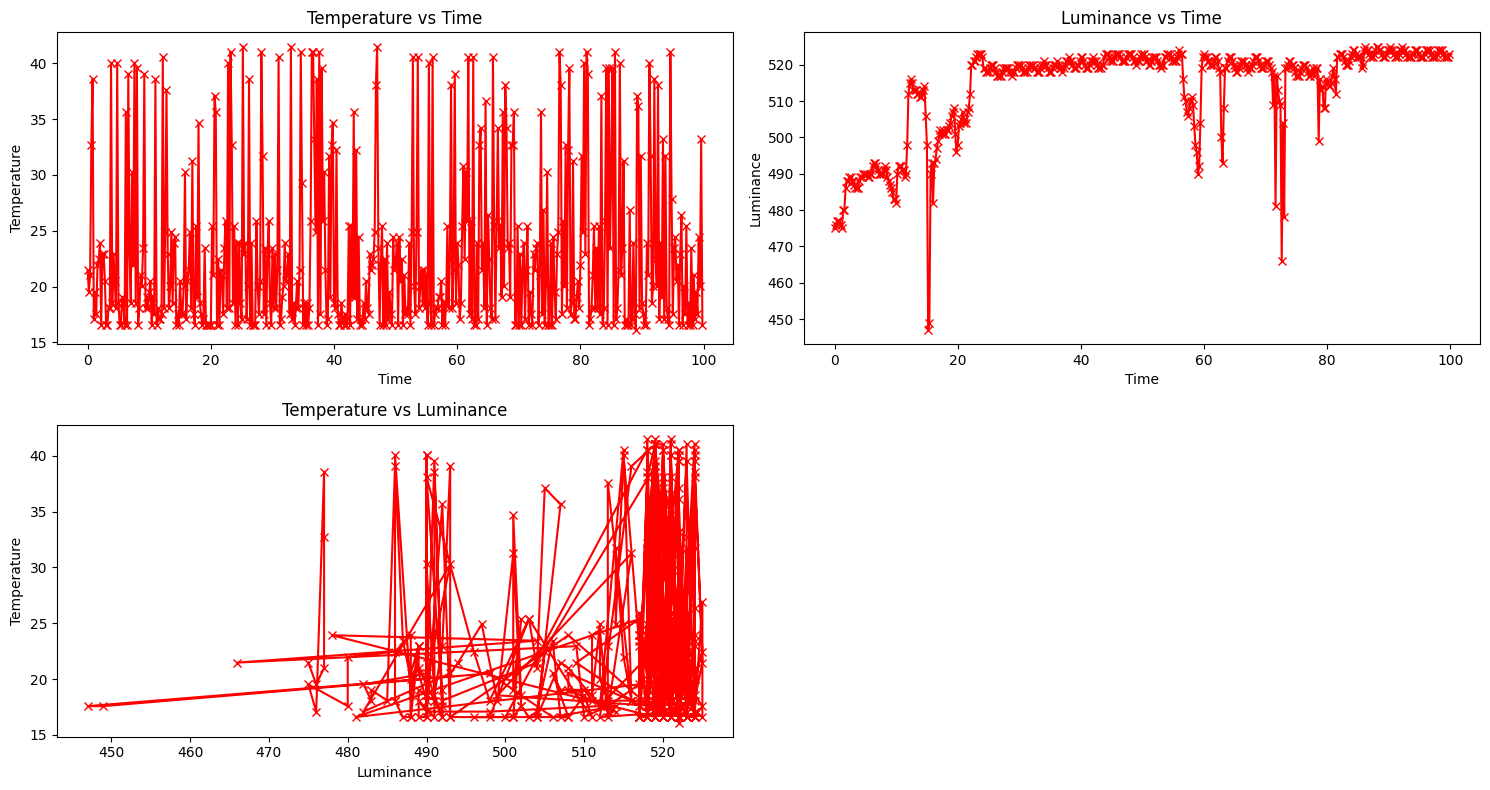

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("assignment2.csv", sep = ';', header = None, skiprows = 1)
#Cleaning data
df[0] = df[0].str.replace('\r\n', '')
df[['Temperature', 'Luminance', 'Time']] = df[0].str.extract(r'(\d+\.\d+);(\d+),(\d+\.\d+)')
df['Temperature'] = df['Temperature'].astype(float)
df['Luminance'] = df['Luminance'].astype(int)
df['Time'] = df['Time'].astype(float)
df = df.drop(0, axis=1)

plt.figure(figsize = (15, 8))
#Plot Temperature against time
plt.subplot(2, 2, 1)
plt.plot(df['Time'], df['Temperature'], marker = 'x', linestyle = '-', color = 'r')
plt.title('Temperature vs Time')
plt.xlabel('Time')
plt.ylabel('Temperature')

#Plot Temperature against time
plt.subplot(2, 2, 2)
plt.plot(df['Time'], df['Luminance'], marker = 'x', linestyle = '-', color = 'r')
plt.title('Luminance vs Time')
plt.xlabel('Time')
plt.ylabel('Luminance')

#Plot Temperature against time
plt.subplot(2, 2, 3)
plt.plot(df['Luminance'], df['Temperature'], marker = 'x', linestyle = '-', color = 'r')
plt.title('Temperature vs Luminance')
plt.xlabel('Luminance')
plt.ylabel('Temperature')

plt.tight_layout()
plt.show()

## 2) Databases

For the databases part of this assignment, you will use the mimic-iii database from the laboratory session. Start by adding a few new tables to the database, using the SQL files included in the assignment's files. Open PGAdmin and connect to your mimic-iii database. **To properly load these tables, load the following files exactly and by the order presented.**

1) Run demographic.sql

2) Run lab_firstday.sql

You will now have to answer a few SQL questions.

**1.** Open the connection to your mimic-iii database. If you want, you can delete your credentials before submitting the assignment, but if you do so, please run the notebook first, for the results to be displayed.

In [25]:
import psycopg2 as psql

conn = psql.connect(host='localhost',
                    database='mimic-iii',
                    user='postgres',
                    password='IamTheAdmin',
                    port=5432)

**2.** Create a function that receives an SQL query and automatically opens a cursor, queries the database, extracts the columns, creates a pandas database, and closes the connections.

In [26]:
def sql_query (query):
    connection_parameters = { 
                    'host':'localhost',
                    'database':'mimic-iii',
                    'user': 'postgres',
                    'password': 'IamTheAdmin',
                    'port': 5432
    }
    
    conn = psql.connect(**connection_parameters)
    
    cursor = conn.cursor()

    try:
        cursor.execute(query)
        columns = [column[0] for column in cursor.description]
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns = columns)
        return df
    finally:
        cursor.close()
        conn.close()


**3.** Query the table admissions filtering for admission type as emergency and insurance as private.

In [27]:
query = """
SELECT * 
FROM admissions 
WHERE admission_type = 'EMERGENCY' 
AND insurance = 'Private'
"""
result_df = sql_query(query)
print(result_df.head())

   row_id  subject_id  hadm_id           admittime           dischtime  \
0   12263       10011   105331 2126-08-14 22:32:00 2126-08-28 18:59:00   
1   12317       10067   160442 2130-10-06 01:34:00 2130-10-06 02:29:00   
2   12339       10088   149044 2107-05-12 18:00:00 2107-05-18 13:30:00   
3   12341       10090   176805 2124-01-12 14:26:00 2124-01-14 19:00:00   
4   12349       10098   180685 2170-12-02 23:24:00 2170-12-03 15:55:00   

            deathtime admission_type         admission_location  \
0 2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
1 2130-10-06 02:29:00      EMERGENCY       EMERGENCY ROOM ADMIT   
2                 NaT      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                 NaT      EMERGENCY       EMERGENCY ROOM ADMIT   
4 2170-12-03 15:55:00      EMERGENCY       EMERGENCY ROOM ADMIT   

         discharge_location insurance language       religion  \
0              DEAD/EXPIRED   Private     None       CATHOLIC   
1              DEAD/EX

**4.** Query the table admissions, filtering for the same conditions as the previous exercise (admission type as emergency and insurance as private). Join the "drgcodes" table on the admission ID. Display only the columns regarding the subject id, admission id, time of death, and description of the drug.

In [28]:
query = """
SELECT
    a.subject_id,
    a.hadm_id,
    a.deathtime,
    d.description as drug_description
FROM admissions a
JOIN drgcodes d ON a.hadm_id = d.hadm_id
WHERE admission_type = 'EMERGENCY' 
AND insurance = 'Private'
"""
result_df = sql_query(query)
print(result_df.head())

   subject_id  hadm_id           deathtime  \
0       10130   156668                 NaT   
1       10117   187023                 NaT   
2       10011   105331 2126-08-28 18:59:00   
3       10117   105150 2138-11-18 23:13:00   
4       10106   133283                 NaT   

                                    drug_description  
0  MAJOR SMALL & LARGE BOWEL PROCEDURES WITH COMP...  
1  DENTAL & ORAL DIS EXCEPT EXTRACTIONS & RESTORA...  
2  DISORDERS OF LIVER EXCEPT MALIGNANCY, CIRRHOSI...  
3  SIMPLE PNEUMONIA & PLEURISY AGE >17 WITH COMPL...  
4   NERVOUS SYSTEM INFECTION EXCEPT VIRAL MENINGITIS  


**5.1.** Obtain the dataset for this problem, by running the SQL query below.

In [29]:
query = "SELECT pivoted_lab.*," +\
                "gender as gender," +\
                "admission_age," +\
                "ethnicity_grouped as eth_grp," +\
                "hospital_expire_flag," +\
                "los_icu " +\
        "FROM demographics " +\
        "LEFT JOIN pivoted_lab " +\
        "ON demographics.icustay_id = pivoted_lab.icustay_id " +\
        "WHERE first_icu_stay = true"

result_df = sql_query(query)
print(result_df.head())

   subject_id  hadm_id  icustay_id  aniongap_min  aniongap_max  albumin_min  \
0       10006   142345      206504          12.0          20.0          2.7   
1       10011   105331      232110          12.0          12.0          2.6   
2       10013   165520      264446          13.0          13.0          NaN   
3       10017   199207      204881          13.0          13.0          2.8   
4       10019   177759      228977          20.0          46.0          3.2   

   albumin_max  bands_min  bands_max  bicarbonate_min  ...  sodium_max  \
0          3.4        NaN        NaN             29.0  ...       139.0   
1          2.6        2.0        2.0             23.0  ...       136.0   
2          NaN       13.0       13.0             29.0  ...       138.0   
3          2.8        NaN        NaN             29.0  ...       139.0   
4          3.2        NaN        NaN             10.0  ...       141.0   

   bun_min  bun_max  wbc_min  wbc_max  gender  admission_age  eth_grp  \
0      

**5.2.** Close the connection to your SQL server.

In [30]:
conn.close()

**5.3.** Prepare your dataset:

* Drop the ID columns of subject, admission and ICU stay.
* Drop columns with at least one NA value.
* Encode the categorical columns, the ethnicity and gender ('eth_grp', 'gender'). *Suggestion: use pd.get_dummies*
* Consider the column 'hospital_expire_flag' as the response and all remaining columns as the predictors.

In [31]:
df_prepared = result_df.drop(['subject_id','hadm_id', 'icustay_id'], axis = 1)
df_prepared = df_prepared.dropna(axis = 1)
df_prepared = pd.get_dummies(df_prepared, columns = ['eth_grp', 'gender'])
x = df_prepared.drop('hospital_expire_flag', axis = 1)
y = df_prepared['hospital_expire_flag']

**6.** Fit the following tree-based classifiers to the dataset. For each method:

* Perform k-fold cross validation to evaluate the models. Consider 10 folds.

* Plot the ROC curves for each fold, along with the mean ROC curve.

* Calculate the mean AUC.

**a.** Decision tree.

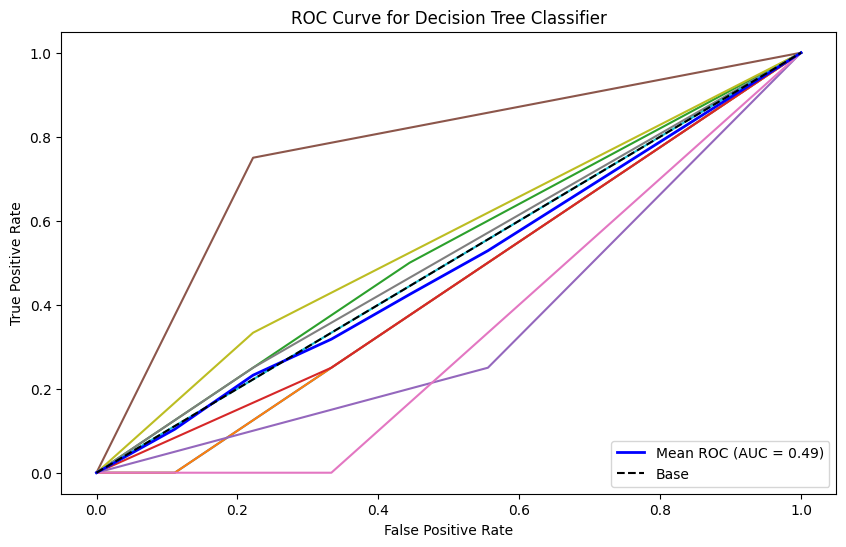

In [40]:
import numpy as np
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

dt_classifier = DecisionTreeClassifier(random_state = 42)

dt_pred = cross_val_predict(dt_classifier,x , y, cv = 10, method = 'predict_proba')

dt_pred = dt_pred[:, 1]

mean_fpr_dt = np.linspace(0, 1, 100)
mean_tpr_dt = 0

plt.figure(figsize = (10, 6))

for train, test in StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).split(x, y):
    dt_classifier.fit(x.iloc[train].values, y.iloc[train].values)
    dt_pred_fold = dt_classifier.predict_proba(x.iloc[test].values)[:, 1]
    fpr, tpr, _ = roc_curve(y.iloc[test].values, dt_pred_fold)
    mean_tpr_dt += np.interp(mean_fpr_dt, fpr, tpr)

    plt.plot(fpr, tpr)

mean_tpr_dt /= StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).get_n_splits()

mean_auc_dt = auc(mean_fpr_dt, mean_tpr_dt)

plt.plot(mean_fpr_dt, mean_tpr_dt, color = 'b', label = f'Mean ROC (AUC = {mean_auc_dt:.2f})', linewidth = 2)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black', label = 'Base')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc = 'lower right')
plt.show()

**b.** Random forest

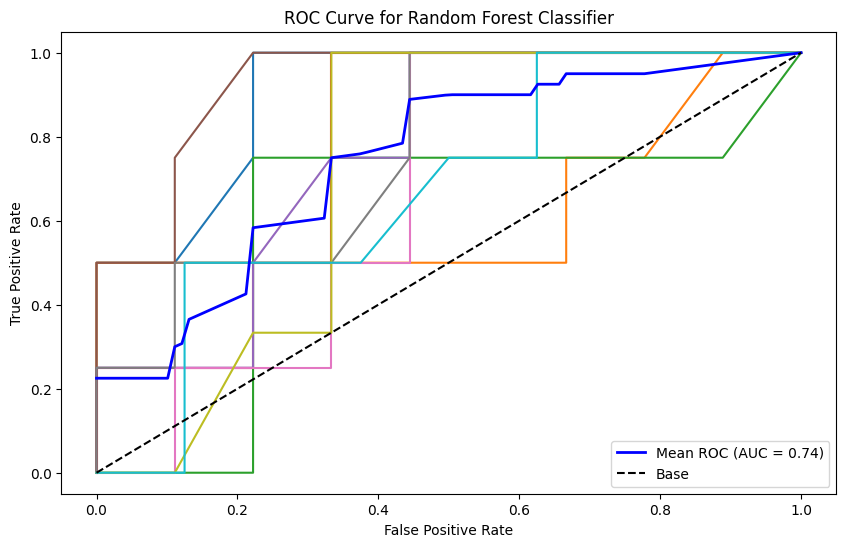

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state = 42)

rf_pred = cross_val_predict(rf_classifier, x, y, cv = 10, method = 'predict_proba')

rf_pred = rf_pred[:, 1]

mean_fpr_rf = np.linspace(0, 1, 100)
mean_tpr_rf = 0

plt.figure(figsize = (10, 6))

for train, test in StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).split(x, y):
    rf_classifier.fit(x.iloc[train].values, y.iloc[train].values)
    rf_pred_fold = rf_classifier.predict_proba(x.iloc[test].values)[:, 1]
    fpr, tpr, _ = roc_curve(y.iloc[test].values, rf_pred_fold)
    mean_tpr_rf += np.interp(mean_fpr_rf, fpr, tpr)

    plt.plot(fpr, tpr)

mean_tpr_rf /= StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).get_n_splits()

mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)

plt.plot(mean_fpr_rf, mean_tpr_rf, color = 'b', label = f'Mean ROC (AUC = {mean_auc_rf:.2f})', linewidth = 2)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black', label = 'Base')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc = 'lower right')
plt.show()

**c.** Gradient Boosting

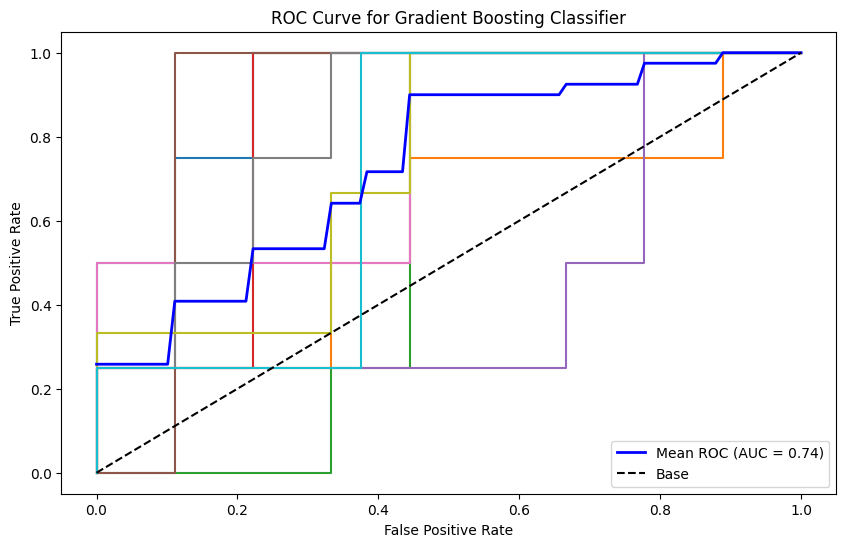

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(random_state = 42)

gb_pred = cross_val_predict(gb_classifier, x, y, cv = 10, method = 'predict_proba')

gb_pred = gb_pred[:, 1]

mean_fpr_gb = np.linspace(0, 1, 100)
mean_tpr_gb = 0

plt.figure(figsize = (10, 6))

for train, test in StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).split(x, y):
    gb_classifier.fit(x.iloc[train].values, y.iloc[train].values)
    gb_pred_fold = gb_classifier.predict_proba(x.iloc[test].values)[:, 1]
    fpr, tpr, _ = roc_curve(y.iloc[test].values, gb_pred_fold)
    mean_tpr_gb += np.interp(mean_fpr_gb, fpr, tpr)

    plt.plot(fpr, tpr)

mean_tpr_gb /= StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).get_n_splits()

mean_auc_gb = auc(mean_fpr_gb, mean_tpr_gb)

plt.plot(mean_fpr_gb, mean_tpr_gb, color = 'b', label = f'Mean ROC (AUC = {mean_auc_gb:.2f})', linewidth = 2)
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'black', label = 'Base')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting Classifier')
plt.legend(loc = 'lower right')
plt.show()

**7.1.** Perform a grid search cross-validation on the Gradient boosting methods, changing the value of the learning rate (0.01 to 0.5) and the number of estimators (50-500). Consider the mean AUC of the folds as the performance measure.

In [43]:
from sklearn.model_selection import GridSearchCV

grid_parameters = {'learning_rate' : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5], 'n_estimators' : [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}

grid_search = GridSearchCV(gb_classifier, grid_parameters, cv = 10, scoring = 'roc_auc', n_jobs = -1)

grid_search.fit(x, y)

best_params_gb = grid_search.best_params_
best_mean_auc_gb = grid_search.best_score_

print('Best Hyperparameters:', best_params_gb)
print(f'Mean AUC: {mean_auc_gb:.4f}')

Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 50}
Mean AUC: 0.7351


**7.2.** Plot a scatterplot of the learning rate versus the number of estimators, with the mean AUC as the color gradient.

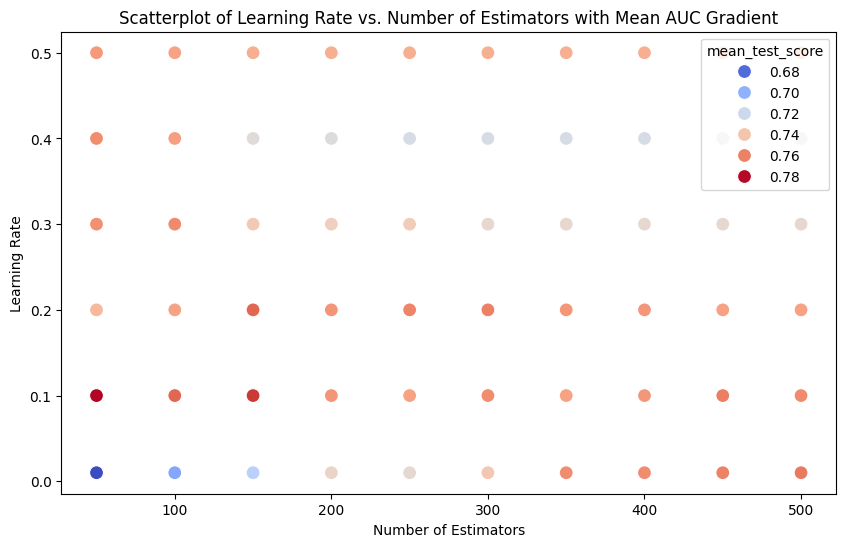

In [44]:
import seaborn as sns

grid_search_results = pd.DataFrame(grid_search.cv_results_)

param_columns = ['param_learning_rate', 'param_n_estimators']
result_columns = ['mean_test_score']

scatter_data = grid_search_results[param_columns + result_columns]

scatter_data.loc[:, 'param_learning_rate'] = pd.to_numeric(scatter_data['param_learning_rate'])

plt.figure(figsize = (10, 6))
scatterplot = sns.scatterplot(
    x = 'param_n_estimators',
    y = 'param_learning_rate',
    hue = 'mean_test_score',
    data = scatter_data,
    palette = 'coolwarm',
    marker = 'o',   
    edgecolor = 'w',
    s = 100
)

plt.xlabel('Number of Estimators')
plt.ylabel('Learning Rate')
plt.title('Scatterplot of Learning Rate vs. Number of Estimators with Mean AUC Gradient')

plt.show()

**8.1.** Perform forward stepwise selection on the dataset. Use the best parameters of the gradient boosting method obtained in **7.1.**.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import statistics
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

best_gb_classifier = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 50, random_state = 42)

features = []
auc_scores = []

for feature in x_train.columns:
    features.append(feature)

    best_gb_classifier.fit(x_train[features], y_train)

    y_pred = best_gb_classifier.predict_proba(x_test[features])[:, 1]

    auc = roc_auc_score(y_test, y_pred)
    auc_scores.append(auc)
    print(f'Features: {features}')
    print(f'AUC Score: {auc:.4f}')
mean_auc_ss = statistics.mean(auc_scores)
print('-----------------')
print(f'Mean AUC: {mean_auc_ss:.4f}')

Features: ['bicarbonate_min']
AUC Score: 0.6708
Features: ['bicarbonate_min', 'bicarbonate_max']
AUC Score: 0.5958
Features: ['bicarbonate_min', 'bicarbonate_max', 'creatinine_min']
AUC Score: 0.6167
Features: ['bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max']
AUC Score: 0.6958
Features: ['bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max', 'chloride_min']
AUC Score: 0.4917
Features: ['bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max', 'chloride_min', 'chloride_max']
AUC Score: 0.6917
Features: ['bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_min']
AUC Score: 0.6417
Features: ['bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_min', 'glucose_max']
AUC Score: 0.6333
Features: ['bicarbonate_min', 'bicarbonate_max', 'creatinine_min', 'creatinine_max', 'chloride_min', 'chloride_max', 'glucose_mi

**8.2.** Compare and comment the results from **8.1.** with the features importance obtained through the grid search of queastion **7.1.**.

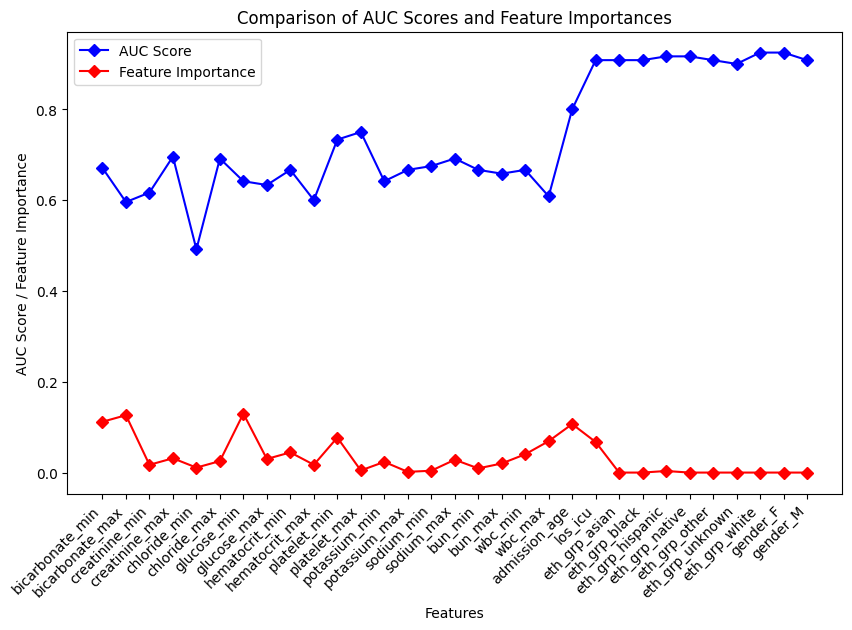

The mean AUC in 8.1(0.7415) is higher than the mean AUC obtained in 7.1(0.7351).
This indicates that choosing specific features in 8.1 led to an overall imporvement
in the model across differnt feature combinations.


In [46]:
best_gb_classifier.fit(x, y)

features_importances = best_gb_classifier.feature_importances_

plt.figure(figsize = (10, 6))
plt.plot(features, auc_scores, marker = 'D', linestyle = '-', color = 'b', label = 'AUC Score')
plt.plot(features, features_importances, marker = 'D', linestyle = '-', color = 'r', label = 'Feature Importance')
plt.xlabel('Features')
plt.ylabel('AUC Score / Feature Importance')
plt.title('Comparison of AUC Scores and Feature Importances')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()
plt.show()

print(f'The mean AUC in 8.1({mean_auc_ss:.4f}) is higher than the mean AUC obtained in 7.1({mean_auc_gb:.4f}).\nThis indicates that choosing specific features in 8.1 led to an overall imporvement\nin the model across differnt feature combinations.')

## 3) Theoretical Questions

**1.** Consider a dataset where best subset, forward stepwise and backward stepwise selection will be performed. For each of the 3 approaches, we obtain $p+1$ models, $p$ being the total number of predictors. This means that each approach has a model with 0 predictors, one with 1 predictor, one with 2 predictor, up until one model with $p$ predictors. Answer and justify the following questions:

**a)** Which of the three models with $k, \, \forall_{k \in [0,p]}$ predictors has the smallest training RSS?

In best subset selection, the model with $k$ predictors is the model with the smallest RSS among all $C_k^p$ models with $k$ predictors. For backward stepwise selection, the model with $k$ predictors is the model with the smallest RSS among the $k$ models that include all but one of the predictors in $M_{k+1}$. In forward stepwise selection, the k-predictor model is the model with the smallest RSS among the $p-k$ models that add one predictor to the predictors in $M_{k-1}$. Hence, the k-predictor model with the smallest training RSS is the one obtained from the best subset selection, as it is the one selected from all k-predictor models.

**b)** Which of the three models with $k, \, \forall_{k \in [0,p]}$ predictors has the smallest test RSS?

It's likely that the best subset selection method may have the smallest test RSS because it considers more models than the other methods. However it is also possible that the other methods may by chance select a model with a smaller test RSS.

**c)** Evaluate the following statements with *true* or *false*. Justify your answers.

    i. The predictors in the k-variable model identified by forward stepwise selection are a subset of the predictors in the (k+1)-variable model identified by forward stepwise selection.

T, the process involves iteratively adding the most statistically significant variable at each step, gradually expanding the model.

    ii. The predictors in the k-variable model identified by backward stepwise selection are a subset of the predictors in the (k + 1)-variable model identified by backward stepwise selection.

T, in backward stepwise selection, as variables are removed from the model, the k-variable model is a subset of the (k + 1)-variable model. This process continues until the best subset of predictors is identified.

    iii. The predictors in the k-variable model identified by backward stepwise selection are a subset of the predictors in the (k + 1)-variable model identified by forward stepwise selection.

F, in backward stepwise selection, predictors are removed from the model, resulting in a reduced set of variables. In forward stepwise selection, variables are added one at a time, so the k-variable model identified by backward stepwise selection is not necessarily a subset of the (k + 1)-variable model identified by forward stepwise selection.

    iv. The predictors in the k-variable model identified by forward stepwise selection are a subset of the predictors in the (k+1)-variable model identified by backward stepwise selection.

F, There is no direct correlation between the obtained models.

    v. The predictors in the k-variable model identified by best subset selection are a subset of the predictors in the (k + 1)-variable model identified by best subset selection.

F, best subset selection considers all possible subsets of predictors for each model size and selects the best one based on a criterion (e.g., adjusted R-squared). Therefore, the k-variable model identified by best subset selection may not necessarily be a subset of the (k + 1)-variable model. It evaluates all combinations and chooses the best model independently for each size.

**2.** Ridge regression tends to give similar coefficient values to correlated variables, whereas lasso regression may give substantially different coefficients to correlated variables. This questions explores this property in a simplified setting.

Suppose that $n=2$, $p=2$, $x_{11} = x_{12}$, $x_{21} = x_{22}$. Moreover, suppose that $y_1 + y_2 = 0$ and $x_{11} + x_{21} = 0$ and $x_{12} + x_{22} = 0$, meaning that the estimate for the intercept in a least squares, ridge regression, or lasso regression is zero: $\hat{\beta} = 0$.

**a)** Write the ridge regression optimization problem in this setting.


Minimize $(y_{1}-\hat{\beta_1} x_{1}-\hat{\beta_2} x_{1})^2 +(y_{2}-\hat{\beta_2} x_{2}-\hat{\beta_2} x_{2})^2+\lambda(\hat{\beta_1}^2+\hat{\beta_2}^2)$

**b)** Prove that in this setting, the ridge regression coefficient estimates satisfy $\hat{\beta}_1 = \hat{\beta}_2$.

By taking the derivatives of the above expression with respect to $\hat{\beta}_1$ and $\hat{\beta}_2$ and setting them equal to 0, we obtain respectively:
$\hat{\beta}_1(x_1^2+x_2^2+\lambda)+\hat{\beta}_2(x_1^2+x_2^2)=y_1x_1+y_2x_2$
and
$\hat{\beta}_1(x_1^2+x_2^2)+\hat{\beta}_2(x_1^2+x_2^2+\lambda)=y_1x_1+y_2x_2$
By substracting the two expressions we get $\hat{\beta}_1 = \hat{\beta}_2$.ely

**c)** Write the lasso regression optimization problem in this setting.

Minimize $(y_1-\hat{\beta}_1x_1-\hat{\beta}_2x_1)^2+(y_2-\hat{\beta}_1x_2-\hat{\beta}_2x_2)^2+\lambda(|\hat{\beta}_1|+|\hat{\beta}_2|)$

**d)** Prove that in this setting, the lasso regression coefficients $\hat{\beta}_1$ and $\hat{\beta}_2$ are not unique, meaning that there are many possible solutions to the optimization problem in (c). Describe these solutions.

$(y_1-\hat{\beta}_1x_1-\hat{\beta}_2x_1)^2+(y_2-\hat{\beta}_1x_2-\hat{\beta}_2x_2)^2$ subject to $|\hat{\beta}_1|+|\hat{\beta}_2|\leq s$ <br>
We have to minimize the expression: $2[y_1-(\hat{\beta}_1+\hat{\beta}_2)x_1]^2\geq 0$ <br> where <br>
$\hat{\beta}_1+\hat{\beta}_2=y_1/x_1$ <br> So the solations are: <br>
${(\hat{\beta}_1,\hat{\beta}_2):\hat{\beta}_1+\hat{\beta}_2=s \ with \  \hat{\beta}_1,\hat{\beta}_2\geq0 \ and \  \hat{\beta}_1+\hat{\beta}_2=-s \ with \  \hat{\beta}_1,\hat{\beta}_2\leq0}$

**3.** Draw an example of a partition of two-dimensional feature space that could result from recursive binary splitting. Your example should contain at least six regions. Draw a decision tree corresponding to this partition. Be sure to label all aspects of your figures, including the regions R1, R2,..., the cutpoints t1, t2,..., and so forth.

If you prefer you can draw it by hand or in any software and use a scan of it.

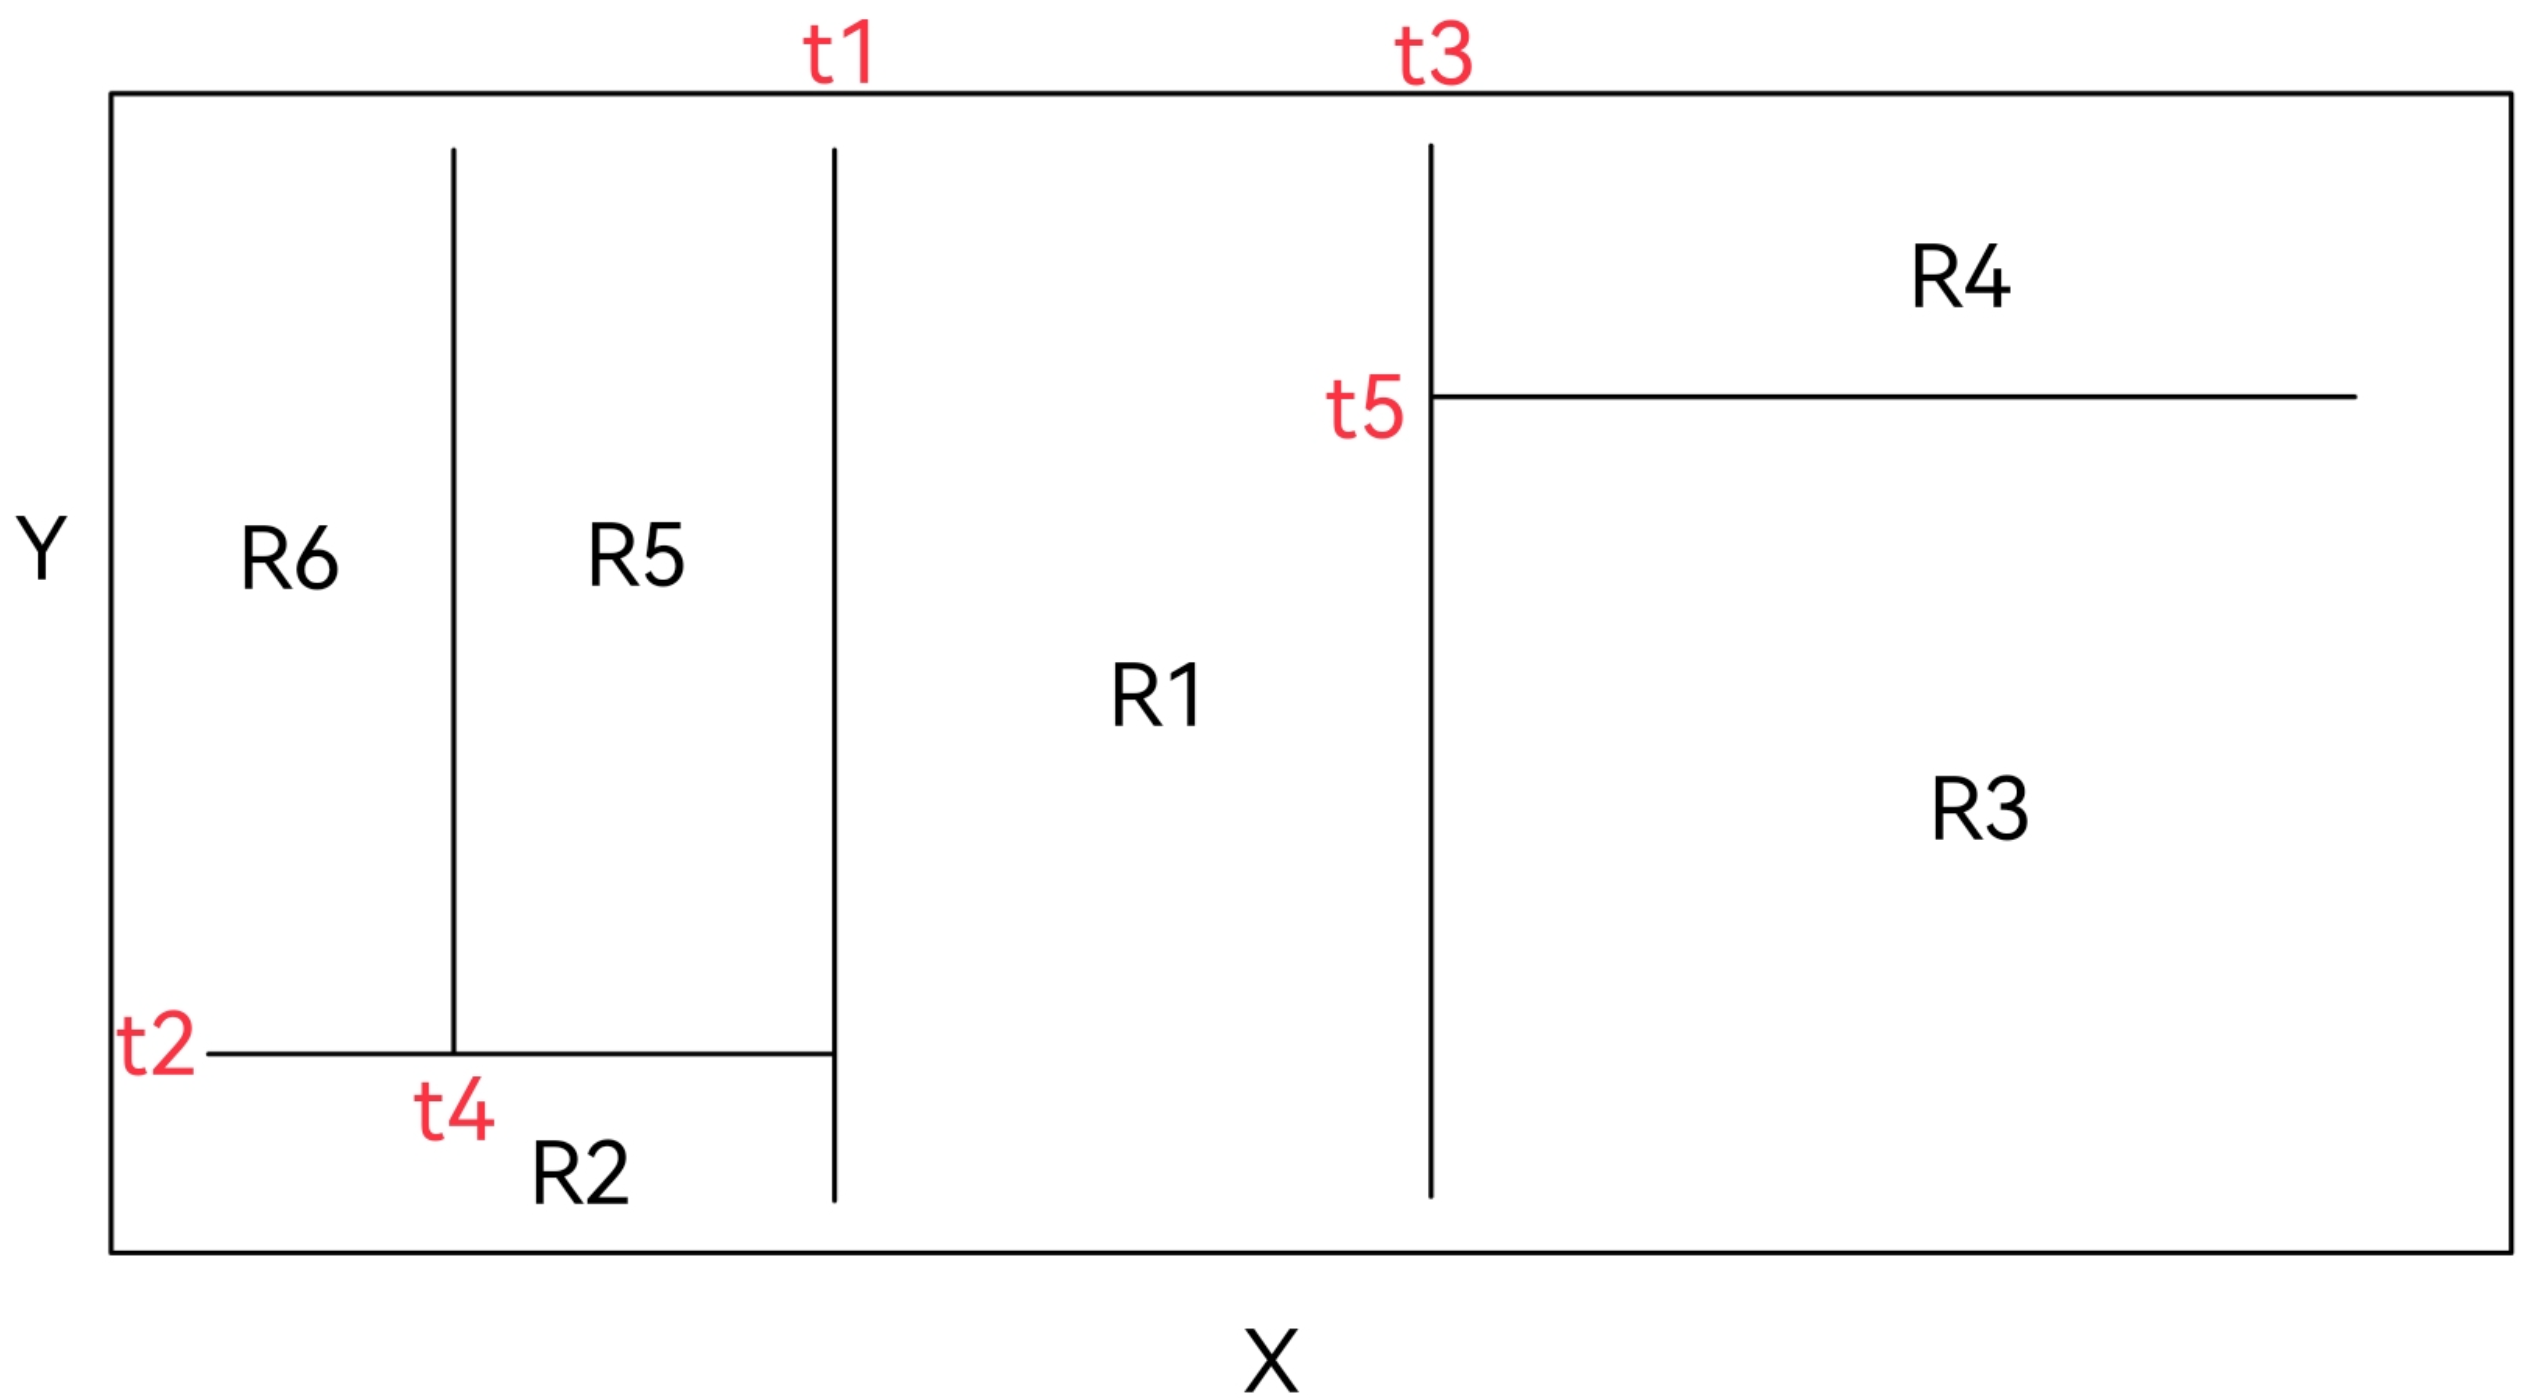

**4.** In 2 dimensions, a linear decision boundary takes the form $\beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0$. Consider a nn-linear decision boundary:

**a)** Sketch the curve

$$(1 + X_1)^2 + (2 - X_2)^2 = 4$$

Additionally, indicate on your sketch the set of points that verify the condition

$$(1 + X_1)^2 + (2 - X_2)^2 > 4$$

and the condition

$$(1 + X_1)^2 + (2 - X_2)^2 \leq 4$$

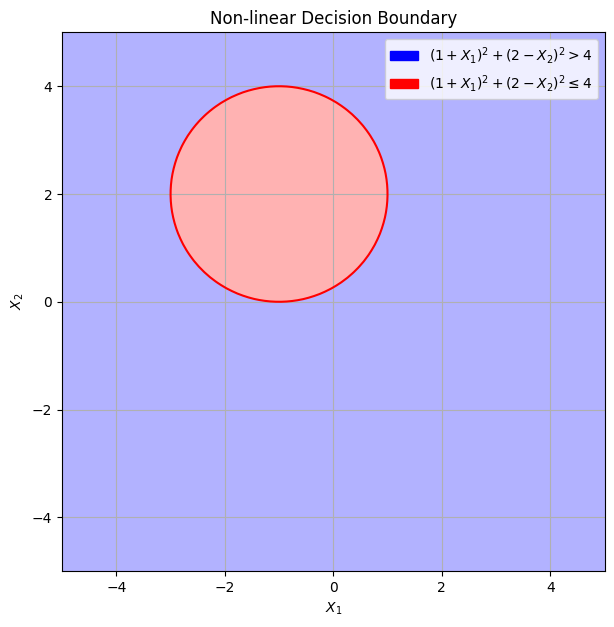

In [39]:
import matplotlib.patches as mpatches

def circle_condition(X1, X2):
    return (1 + X1)**2 + (2 - X2)**2 - 4

X1 = np.linspace(-5, 5, 100)
X2 = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(X1, X2)

Z_circle = circle_condition(X1, X2)

plt.figure(figsize = (7, 7))
contour_circle = plt.contour(X1, X2, Z_circle, levels = [0], colors = 'r')

red_patch = mpatches.Patch(color = 'r', label = '$(1 + X_1)^2 + (2 - X_2)^2 \leq 4$')
plt.contourf(X1, X2, Z_circle, levels=[-np.inf, 0], colors = 'r', alpha = 0.3)

blue_patch = mpatches.Patch(color = 'b', label = '$(1 + X_1)^2 + (2 - X_2)^2 > 4$')
plt.contourf(X1, X2, Z_circle, levels = [0, np.max(Z_circle)], colors = 'b', alpha = 0.3)

plt.legend(handles = [blue_patch, red_patch], loc = 'upper right')

plt.title('Non-linear Decision Boundary')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.show()

**b)** Suppose that a classifier assigns an observation to the blue class if $(1 + X_1)^2 + (2 - X_2)^2 > 4$ and to the red class otherwise. To what class are the following observations classified? (0,0), (-1,1), (2,2), (3,8)

For observation (0,0): <br>
$$(1+0)^2 + (2-0)^2 =1 + 4=5>4 => Blue Class$$

For observation (-1,1): <br>
$$(1+(-1))^2 + (2-1)^2 =0 + 1=1\leq4 => Red Class$$

For observation (2,2): <br>
$$(1+2)^2 + (2-2)^2 =9 + 0=9>4 => Blue Class$$

For observation (3,8): <br>
$$(1+3)^2 + (2-8)^2 =16 + 36=52>4 => Blue Class$$

**c)** Prove that while the decision boundary in (b) is not linear in terms of $X_1$ and $X_2$, it is linear in terms of $X_1$, $X_1^2$, $X_2$, and $X_2^2$.

$$(1 + X_1)^2 + (2 - X_2)^2 = 4 <=> X_1 ^2 + 2X_1 + X_2 ^2 - 4X_2 +1 = 0$$ 
In this way we have a linear decision boundary in terms of $X_1$, $X_1^2$, $X_2$, and $X_2^2$.

# 4) Laboratory Questions

What are the advantages and disadvantages of relational dabases versus graph databases, and when should one type be preferred over the other?

Relational databases are highly effective in managing structured data with defined relationships and ensuring data integrity through ACID (Atomicity Consistency Isolation Durability) compliance. As a result, they are widely used in scenarios that prioritize a solid data structure. However, they face challenges when dealing with complex queries and scaling highly interconnected data. In contrast, graph databases are specifically designed to handle interconnected data efficiently and excel in relationship-centric queries. They offer flexibility for evolving data models, but sacrifice some ACID properties for enhanced performance. Graph databases are well-suited for applications where understanding and traversing relationships are central, such as social networks or recommendation systems. The choice between the two options depends on the nature of your data and the importance of relationships in your application. If you have structured data with clear relationships and strong ACID requirements, a relational database is the best option. On the other hand, if you are managing highly interconnected data and navigating relationships is a primary focus, a graph database is more suitable.